In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxopt

In [244]:
def read_csv_to_dataframe(file_path):
    dataframe = pd.read_csv(file_path)
    return dataframe

In [245]:
# Code for plotting the data.
def plot_data(df, x_column, y_column, color_column):
    dataframe = df.copy(deep=False)
    dataframe['Model'] = dataframe['Model'].replace('Series N', 'red').replace('Series M', 'blue').replace('Series L', 'green')
    plt.scatter(dataframe[x_column], dataframe[y_column], c=dataframe[color_column])
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"Scatter plot of {y_column} vs {x_column}")
    plt.show()

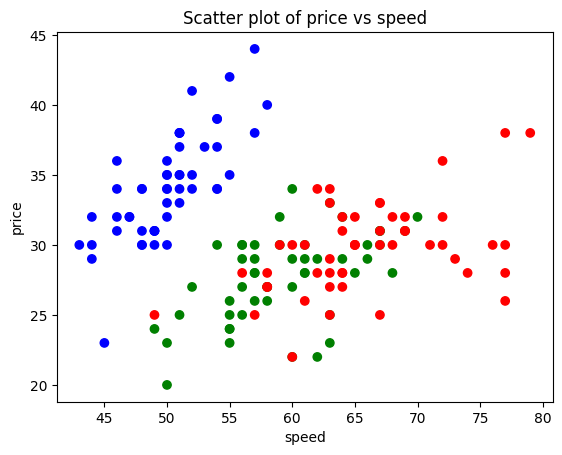

In [246]:
file_path = 'dataset_1.csv' 
df = read_csv_to_dataframe(file_path)
plot_data(df, 'speed', 'price', 'Model')

In [247]:
# ------------------------------------------1. Implement a OVR SVM classifier. -----------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [248]:
def get_svm_weight_vector_and_intercept(X, y, C):
    row, col = X.shape
    K = np.zeros((row, row))
    for i in range(row):
        for j in range(row):
            K[i,j] = np.dot(X[i], X[j])

    # Constructing optimization problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(row))
    A = cvxopt.matrix(y, (1, row))
    b = cvxopt.matrix(0.0)

    tmp1 = np.diag(np.ones(row) * -1)
    tmp2 = np.identity(row)
    G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
    tmp1 = np.zeros(row)
    tmp2 = np.ones(row) * C
    h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': False})

    # Langrange dual
    a = np.ravel(solution['x'])

    sv = a > 1e-5
    sv_indices = np.arange(len(a))[sv]
    sv_a = a[sv]
    sv_X = X[sv]
    sv_y = y[sv]

    weight_vector = np.zeros(col)
    for i in range(len(sv_a)):
        weight_vector += sv_a[i] * sv_y[i] * sv_X[i]

    intercept = 0
    for n in range(len(sv_a)):
        intercept += sv_y[n]
        intercept -= np.sum(sv_a * sv_y * K[sv_indices[n], sv])
    intercept /= len(sv_a)

    return weight_vector, intercept, len(sv_X)


In [249]:
# --------------------------------- Finding the optimal penalty (or regularization) parameter --------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [250]:
def condition_function(x, y):
    value_1 = (weight_vector_m[0] * x + weight_vector_m[1] * y + intercept_m)
    value_2 = (weight_vector_n[0] * x + weight_vector_n[1] * y + intercept_n) 
    value_3 = (weight_vector_l[0] * x + weight_vector_l[1] * y + intercept_l) 
    if value_1 >= value_2 and value_1 >= value_3:
        return 0
    if value_2 >= value_1 and value_2 >= value_3:
        return 1
    if value_3 >= value_2 and value_3 >= value_1:
        return 2

In [251]:
X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64)

c_list = []
error_list = []
support_vector_list = []
for c in np.arange(0.0001, 0.2, 0.0005):
    c = round(c, 4)
    c_list.append(c)
    
    weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept(X, y_m, c)
    weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept(X, y_n, c)
    weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept(X, y_l, c)
    
    error = 0
    for i in range(len(X)):
        value = condition_function(X[i][0], X[i][1])
        if value == 0 and i >= 50:
            error += 1
        if value == 1 and i < 50 and i >=100:
            error += 1
        if value == 2 and i < 100:
            error += 1
    error_list.append(error)
    support_vector_list.append(support_vectors)

In [252]:
# ------ plot the number of violated points (misclassified points) and number of support vectors on Y axis against different values C on X-axis.------
# ----------------------------------------------------------------------------------------------------------------------------------------------------

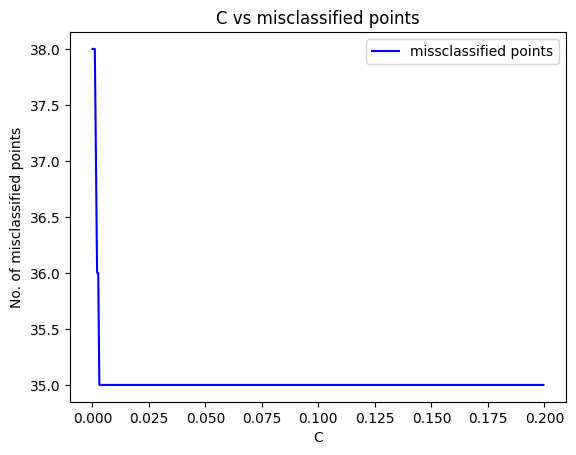

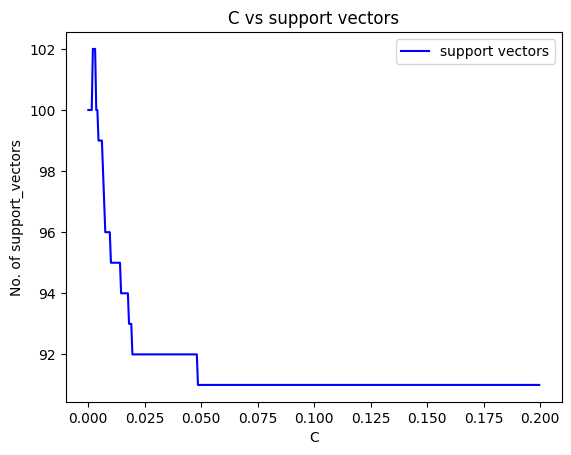

In [253]:
plt.plot(c_list, error_list, color = 'blue', label = 'missclassified points')
plt.xlabel('C')
plt.ylabel('No. of misclassified points')
plt.title('C vs misclassified points')
plt.legend()
plt.show()

plt.plot(c_list, support_vector_list, color = 'blue', label = 'support vectors')
plt.xlabel('C')
plt.ylabel('No. of support_vectors')
plt.title('C vs support vectors')
plt.legend()
plt.show()

In [269]:
# Plotting the hyperplanes obtained from SVM.
def plot_svm_hyperplanes(df, line_x, line_y_m, line_y_n, line_y_l):
    dataframe = df
    x_column = 'speed'
    y_column = 'price'
    x_values = dataframe[x_column].values.tolist()
    line_x = np.linspace(min(x_values), max(x_values), 100)

    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    plt.plot(line_x, line_y_m, color='purple', label='M vs non-M')
    plt.plot(line_x, line_y_n, color='yellow', label='N vs non-N')
    plt.plot(line_x, line_y_l, color='black', label='L vs non-L')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xlim(40, 80)
    plt.ylim(15, 50)
    plt.title(f"Scatter plot of {y_column} vs {x_column}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

In [270]:
# --------------------------------------------------------------------------------------------------------------------
# ------------------------------------------- Plotting the optimal classifier ----------------------------------------

In [295]:
# Finding the equation of hyperplane.
X = np.array(df[['speed', 'price']].values.tolist())
C = 0.05

y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 
weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept(X, y_m, C)
weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept(X, y_n, C)
weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept(X, y_l, C)

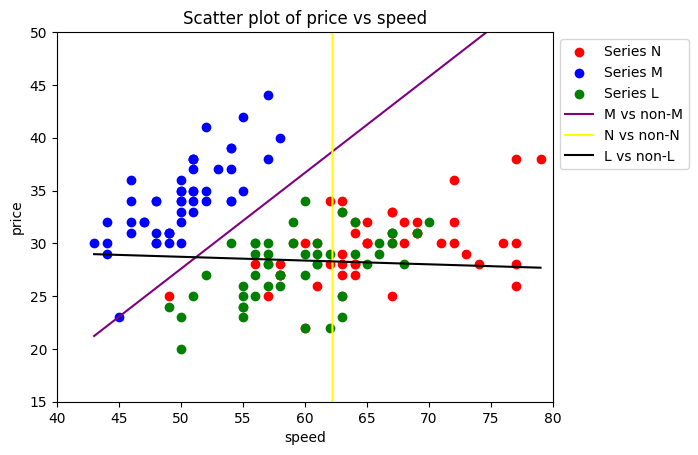

In [296]:
x_column = 'speed'
y_column = 'price'
dataframe = df.copy(deep=False)
x_values = df[x_column].values.tolist()
line_x = np.linspace(min(x_values), max(x_values), 100)
line_y_m = - (weight_vector_m[0] * line_x + intercept_m) / weight_vector_m[1]
line_y_n = - (weight_vector_n[0] * line_x + intercept_n) / weight_vector_n[1]
line_y_l = - (weight_vector_l[0] * line_x + intercept_l) / weight_vector_l[1]
plot_svm_hyperplanes(df, line_x, line_y_m, line_y_n, line_y_l)

In [297]:
# Plotting desicion boundary of SVM.
def plot_svm_decision_boundary():
    x_min, x_max = 40, 80
    y_min, y_max = 15, 50
    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    condition_values = np.vectorize(condition_function)(xx, yy)
    plt.contourf(xx, yy, condition_values, levels=[-0.5, 0.5, 1.5, 2.5], colors=('blue', 'red', 'green'),  alpha=0.3)
    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    plt.xlabel('Speed')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Coloring the X-Y Plane based on SVM decision boundary')
    plt.show()

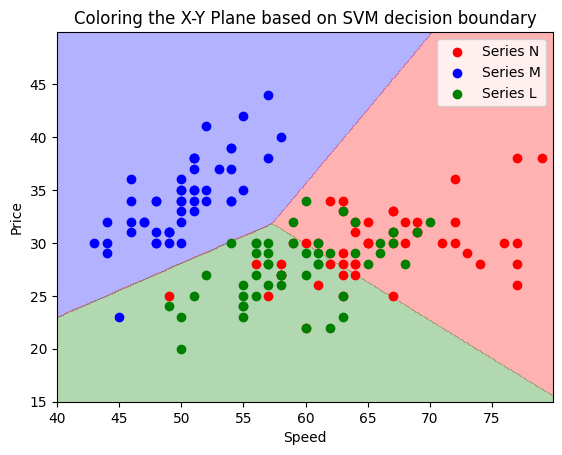

In [298]:
plot_svm_decision_boundary()